## Introduction to Modeling with Python

Now that we have seen some examples of modeling and using Python for modeling, we wanted to give you a chance to try your hand!

To that goal, we choose a well structured problem with plenty of resources online to help you along the way. That problem is predicting housing prices and is hosted on Kaggle:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

First, make sure you are signed up on Kaggle and then download the data:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The data includes both testing and training sets as well as a sample submission file. 

Your goal is the predict the sales price for each house where root mean squared error is the evaluation metric. To get some ideas on where to start, feel free to check out Kaggle Kernels:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

And the discussion board:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion

Again - the goal of this homework is to get you exposed to modeling with Python. Feel free to use online resources to help guide you, but we expect original thought as well. Our hope is by the end of this homework you will feel comfortable exploring data in Python and building models to make predictions. Also please submit your test results to Kaggle and let us know your ranking and score!


### Grading

This homework is due **Feb. 20, 2018 by 3:00pm Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are their assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [722]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor
import seaborn as sns #plt.style.use(“seaborn”)
%matplotlib inline
from scipy import stats
#from statsmodels.iolib.summary2 import summary_col
#summary_col([reg0,reg1,reg2,reg3,reg4])
#from pandas.core import datetools
#pandas.tseries module

My goal is to create a model that predicts housing prices well even outside of sample.  First I'll read in the train and test data.

In [723]:
train=pd.read_csv('train.csv')
train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [724]:
test=pd.read_csv('test.csv')
test.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


I notice that SalePrice is not included in the Kaggle Testing set.  I need to split off a subset of my training set so I can test how accurate my models' predictions for Sale Price are.

In [725]:
X_train, X_test, y_train, y_test = train_test_split(train, train['SalePrice'], test_size=.20, random_state=42)

Here y-train is my target and I will begin by cleaning X_train.

### **Data Cleaning**

I will isolate the variables for which over 50% of the observations are grouped in one category.  I classify these variables as dropped and will not include them in my  models.

In [726]:
dropped = []
for i in X_train:
   if X_train[i].dtype == 'object':
       if X_train[i].value_counts(normalize=True, dropna= False).iloc[0] > .5:
            #print (train[i].value_counts(normalize=True))
            dropped.append(i)

From the documentation provided by Kaggle, I can see that Central Air is a binary variable for whether or not the home has air conditioning.  I don't actually want to drop this because it might be a good indicator of home value and almost certainly more than 50% of homes into either the yes or no category.

In [727]:
dropped.remove('CentralAir')

I'm also going to put the dropped array into a format that is easier to work with later. 

In [728]:
dropped=X_train[['Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']]

I carefully look through the documentation and make some determinations about the categorigal and quantitative variables I have to work with.  There are many categorical variables I can productively convert to dummy variables and a few I may be able to convert to meaningful quantitative variables.  Some qualitative variables such as OverallQual follow a Likert scale and already make sense as quantitatve variables.  I will start by converting MSZoning, Utilities, Neighborhood, RoofStyle, RoofMatl, Exterior1st, BsmtFinType1, FireplaceQu into dummy variables. 

MS Subclass- group by # of stories

Include- LotFrontage, LotArea, OverallQual, OverallCond, MasVnrArea, Foundation, BsmtQual, BasFinSF1,TotalBsmtSF, Fireplaces, CentralAir, FullBath, HalfBath, Bedroom, Kitchen, WoodDeckSF, OpenPorchSF, EnclosedPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, YearBuilt, YearRemodAdd

Make Quantitative- HouseStyle

In [729]:
X_train=pd.get_dummies(X_train, columns=['MSZoning','Utilities','Neighborhood','RoofStyle',
                                   'RoofMatl','Exterior1st', 'BsmtFinType1','FireplaceQu','PavedDrive','Foundation',
                                     'CentralAir'], 
               prefix=['Zone','Utilities','Neighborhood','RoofStyle','RoofMatl','Exterior','BsmtFinish','FireplaceQu',
                       'Paving','Foundation','CentralAir'])
X_train.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,Paving_P,Paving_Y,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y
254,255,20,70.0,8400,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,1,0,1,0,0,0,0,0,1
1066,1067,60,59.0,7837,Pave,NaN,IR1,Lvl,Inside,Gtl,...,0,1,0,0,1,0,0,0,0,1
638,639,30,67.0,8777,Pave,NaN,Reg,Lvl,Inside,Gtl,...,1,0,0,1,0,0,0,0,0,1
799,800,50,60.0,7200,Pave,NaN,Reg,Lvl,Corner,Gtl,...,0,1,1,0,0,0,0,0,0,1
380,381,50,50.0,5000,Pave,Pave,Reg,Lvl,Inside,Gtl,...,0,1,1,0,0,0,0,0,0,1


A quick check to see if this worked properly:

In [730]:
X_train.BsmtFinish_Rec.value_counts(dropna=False)

0    1064
1     104
Name: BsmtFinish_Rec, dtype: int64

Good!  Now I can take a look at making some of our other categorical variables quantitative.

In [731]:
X_train.HouseStyle.value_counts(dropna=False)

1Story    577
2Story    360
1.5Fin    121
SLvl       52
SFoyer     28
1.5Unf     12
2.5Unf     11
2.5Fin      7
Name: HouseStyle, dtype: int64

The most meaningful information I draw from this variable is the number of stories in each home.  Nowhere in our data is this included as its own variable so I will take the opportunity to convert HouseStyle into a quantitative variable that will serve this purpose.  Note that the value counts in the unfinished categories are small.  I will pool these together with their finished counterparts.

In [732]:
X_train['HouseStyle'] = X_train['HouseStyle'].map({'1Story': 1, '1.5Unf': 1.5, '1.5Fin':1.5, '2Story':2,'SFoyer':2,
                                              '2.5Unf':2.5,'2.5Fin':2.5, 'SLvl':2.5})

Here I classify Split-Foyer homes in the same quantitative category as two story homes because they are typically designed with a set of downward stairs and upwards stairs that lead out of the small foyer area into the two main levels of the home.  I likewise classify Split Level Homes (often called "Tri-Level" homes) in the same category as finished 2.5 story homes because they are often three levels with one level significantly smaller than the other two.

Let's see how this looks.

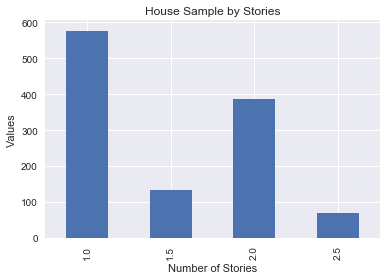

In [733]:
X_train['HouseStyle'].value_counts().sort_index().plot(kind='bar',x=[1,1.5,2.0,2.5])
plt.title('House Sample by Stories')
#plt.xticks([1,1.5,2.0,2.5])
plt.ylabel('Values')
plt.xlabel('Number of Stories')

Let's take a look at another variable I considered including.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

Many of these categories communicate information about number of stories, which we have already reflected in our HouseStyle variable.  There is also some component of home age communicated in this data but only in broad distinctions (Pre and Post 1945) and this is not consistent across all categories.  For this reason, I will decline to include this variable in my models.

Let's take a look at BsmtQual--

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

In [734]:
X_train.BsmtQual.value_counts(dropna=False)

TA     521
Gd     493
Ex      97
Fa      29
NaN     28
Name: BsmtQual, dtype: int64

I intially considered converting this variable into dummies but because there are no houses in the poor category (in which a house could in theory be anywhere from 1 inch to 69 inches) I think it is reasonable to make this variable quantitative by mapping each category into its minimum height.  I will still create a mapping for poor in case a home outside our train sample has a poor basement, but I don't suspect it will be very common.  Less than 6 feet of basement height is pretty awful.

In [735]:
X_train['BsmtQual'] = X_train['BsmtQual'].map({'Po':60, 'Fa':70, 'TA':80, 'Gd':90,'Ex':100})

In [736]:
X_train['BsmtQual']=X_train['BsmtQual'].fillna(0)

In [737]:
X_train['BsmtQual'].value_counts()

80.0     521
90.0     493
100.0     97
70.0      29
0.0       28
Name: BsmtQual, dtype: int64

Now that I've categorized my variables how I like, let's handle missing values.

In [738]:
#train.isnull().any()
X_train.columns[X_train.isnull().any()].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

After cross-checking this list with the list of variables I decided to drop from my regression, I determined that I need to handle missing values for LotFrontage, MasVnrArea, GarageYrBlt, GarageFinish, and BsmtQual.  Taking a glance at the value_counts I decide filling GarageFinish and BsmtQual with the mode and the rest with the mean is reasonable.

In [739]:
X_train['GarageFinish']=X_train['GarageFinish'].fillna(X_train['GarageFinish'].mode())
X_train['LotFrontage']=X_train['LotFrontage'].fillna(X_train['LotFrontage'].mean())
X_train['MasVnrArea']=X_train['MasVnrArea'].fillna(X_train['MasVnrArea'].mean())
X_train['GarageYrBlt']=X_train['GarageYrBlt'].fillna(X_train['GarageYrBlt'].mean())

In [740]:
X_train['GarageFinish'].value_counts()

Unf    480
RFn    339
Fin    285
Name: GarageFinish, dtype: int64

In [741]:
X_train=pd.get_dummies(X_train, columns=['GarageFinish'])

In [742]:
X_train['GarageFinish_Unf'].value_counts()

0    688
1    480
Name: GarageFinish_Unf, dtype: int64

Let's check that this cleared up our missing values.

In [743]:
X_train['LotFrontage'].isnull().head(20)

254     False
1066    False
638     False
799     False
380     False
303     False
86      False
1385    False
265     False
793     False
1445    False
808     False
1099    False
605     False
701     False
221     False
113     False
548     False
1073    False
174     False
Name: LotFrontage, dtype: bool

In [744]:
#train.isnull().any()
X_train.columns[X_train.isnull().any()].tolist()

['Alley',
 'MasVnrType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [745]:
X_train=X_train.drop(dropped,axis=1)

In [746]:
X_train.dtypes

Id                     int64
MSSubClass             int64
LotFrontage          float64
LotArea                int64
HouseStyle           float64
OverallQual            int64
OverallCond            int64
YearBuilt              int64
YearRemodAdd           int64
Exterior2nd           object
MasVnrArea           float64
BsmtQual             float64
BsmtFinSF1             int64
BsmtFinSF2             int64
BsmtUnfSF              int64
TotalBsmtSF            int64
1stFlrSF               int64
2ndFlrSF               int64
LowQualFinSF           int64
GrLivArea              int64
BsmtFullBath           int64
BsmtHalfBath           int64
FullBath               int64
HalfBath               int64
BedroomAbvGr           int64
KitchenAbvGr           int64
TotRmsAbvGrd           int64
Fireplaces             int64
GarageYrBlt          float64
GarageCars             int64
                      ...   
Exterior_Stone         uint8
Exterior_Stucco        uint8
Exterior_VinylSd       uint8
Exterior_Wd Sd

Exterior2nd is still an object and probably not a huge driver of home value so I'm going to drop it from my data frame.

In [747]:
X_train=X_train.drop(['Exterior2nd'],axis=1)

We may also be interested in the presence of outliers in our data.  Let's take a look at the sale prices in our data and determine whether any observations should be dropped before our analysis.

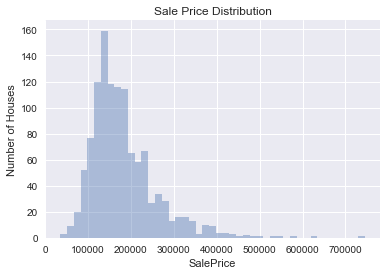

In [748]:
sns.distplot(X_train.SalePrice, kde=False) #kde is kernel density estimate
plt.ylabel('Number of Houses')
plt.title('Sale Price Distribution')

It appears that most homes in our set close for about 100 to 250 thousand dollars.  We can use scipy tools to remove observations lying further than 3 standard deviations from the mean.

In [749]:
y_train.head()

254     145000
1066    178000
638      85000
799     175000
380     127000
Name: SalePrice, dtype: int64

In [750]:
X_train=X_train[(np.abs(stats.zscore(X_train.SalePrice))<3)]
y_train=y_train[(np.abs(stats.zscore(y_train))<3)]

In [751]:
len(y_train)

1151

In [752]:
len(X_train)

1151

We can revisualize to see what has changed--

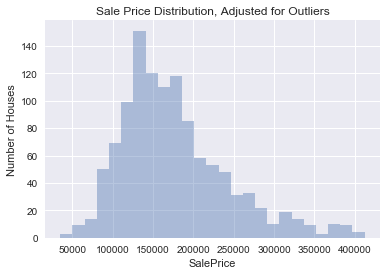

In [753]:
sns.distplot(X_train.SalePrice, kde=False) #kde is kernel density estimate
plt.ylabel('Number of Houses')
plt.title('Sale Price Distribution, Adjusted for Outliers')

And observe that homes above $430,000 (roughly) have been dropped.  We are now ready to scale the data.

### **Scaling**

In [754]:
#Ok to do after cleaning/filling in NaNs
scaler = StandardScaler()
scaler.fit(X_train) #learns mean and std dev for each variable
scaled_Xtrain = scaler.transform(X_train) #Subtracts mean and divides by std dev.
#scaled_Xtest= scaler.transform(X_test)

In [755]:
new_Xtrain = pd.DataFrame(data=scaled_Xtrain, columns=X_train.columns)

In [756]:
new_Xtrain.head()

,Id,MSSubClass,LotFrontage,LotArea,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,-1.119672,-0.866770,-0.003708,-0.202484,-0.925613,-0.813280,0.367079,-0.444465,-1.331801,-0.607259,...,1.133018,-0.882598,-0.132979,-0.066053,-0.05112,-0.278775,0.278775,-0.558953,1.564004,-0.844273
1,0.786585,0.069443,-0.498216,-0.255036,1.014971,-0.058981,1.262225,0.734063,0.452551,-0.607259,...,-0.882598,1.133018,-0.132979,-0.066053,-0.05112,-0.278775,0.278775,-0.558953,1.564004,-0.844273
2,-0.218191,-0.632717,-0.138573,-0.167293,-0.925613,-0.813280,1.262225,-1.983099,-1.669381,-0.607259,...,1.133018,-0.882598,-0.132979,-0.066053,-0.05112,-0.278775,0.278775,-0.558953,-0.639385,-0.844273
3,0.159774,-0.164610,-0.453260,-0.314497,0.044679,-0.813280,1.262225,-1.099203,-1.669381,0.938903,...,-0.882598,-0.882598,-0.132979,-0.066053,-0.05112,-0.278775,0.278775,-0.558953,-0.639385,1.184450
4,-0.823874,-0.164610,-0.902813,-0.519854,0.044679,-0.813280,0.367079,-1.524782,-1.669381,-0.607259,...,-0.882598,-0.882598,-0.132979,-0.066053,-0.05112,-0.278775,0.278775,-0.558953,-0.639385,1.184450


In [757]:
X_train.sort_index().head()

,Id,MSSubClass,LotFrontage,LotArea,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,1,60,65.0,8450,2.0,7,5,2003,2003,196.0,...,0,1,0,0,0,0,1,0,1,0
1,2,20,80.0,9600,1.0,6,8,1976,1976,0.0,...,1,0,0,0,0,0,1,0,1,0
2,3,60,68.0,11250,2.0,7,5,2001,2002,162.0,...,0,1,0,0,0,0,1,0,1,0
3,4,70,60.0,9550,2.0,7,5,1915,1970,0.0,...,0,0,0,0,0,0,1,0,0,1
4,5,60,84.0,14260,2.0,8,5,2000,2000,350.0,...,0,1,0,0,0,0,1,0,1,0


In [758]:
controls=new_Xtrain[['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'Foundation_BrkTil',
                'Foundation_CBlock','Foundation_PConc','Foundation_Slab','Foundation_Stone','Foundation_Wood',
                'TotalBsmtSF', 'Fireplaces','CentralAir_Y', 'FullBath', 'HalfBath','WoodDeckSF','OpenPorchSF',
                'EnclosedPorch', 'ScreenPorch','PoolArea', 'MiscVal','MoSold', 'YrSold', 'YearBuilt','YearRemodAdd',
                'Zone_C (all)','Zone_FV','Zone_RH','Zone_RL','Zone_RM','Utilities_AllPub','Utilities_NoSeWa',
                'Neighborhood_Blmngtn','Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide',
                'Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards',
                'Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker','RoofStyle_Flat','RoofStyle_Gable','RoofStyle_Gambrel',
 'RoofStyle_Hip','RoofStyle_Mansard','RoofStyle_Shed','RoofMatl_ClyTile','RoofMatl_CompShg','RoofMatl_Metal',
 'RoofMatl_Roll','RoofMatl_Tar&Grv','RoofMatl_WdShake','RoofMatl_WdShngl','Exterior_AsbShng','Exterior_AsphShn',
 'Exterior_BrkComm', 'BsmtQual','Exterior_BrkFace','Exterior_CBlock','Exterior_CemntBd','Exterior_HdBoard',
 'Exterior_ImStucc','Exterior_MetalSd','Exterior_Plywood','Exterior_Stone','Exterior_Stucco','Exterior_VinylSd',
 'Exterior_Wd Sdng','Exterior_WdShing','BsmtFinish_ALQ','BsmtFinish_BLQ','BsmtFinish_GLQ','BsmtFinish_LwQ',
 'BsmtFinish_Rec','BsmtFinish_Unf','FireplaceQu_Ex','FireplaceQu_Fa','FireplaceQu_Gd','FireplaceQu_Po',
 'FireplaceQu_TA','Paving_N','Paving_P','Paving_Y','BsmtQual']]

In [759]:
controls.dtypes

LotFrontage          float64
LotArea              float64
OverallQual          float64
OverallCond          float64
MasVnrArea           float64
Foundation_BrkTil    float64
Foundation_CBlock    float64
Foundation_PConc     float64
Foundation_Slab      float64
Foundation_Stone     float64
Foundation_Wood      float64
TotalBsmtSF          float64
Fireplaces           float64
CentralAir_Y         float64
FullBath             float64
HalfBath             float64
WoodDeckSF           float64
OpenPorchSF          float64
EnclosedPorch        float64
ScreenPorch          float64
PoolArea             float64
MiscVal              float64
MoSold               float64
YrSold               float64
YearBuilt            float64
YearRemodAdd         float64
Zone_C (all)         float64
Zone_FV              float64
Zone_RH              float64
Zone_RL              float64
                      ...   
Exterior_AsphShn     float64
Exterior_BrkComm     float64
BsmtQual             float64
Exterior_BrkFa

In [760]:
y_train.head()

254     145000
1066    178000
638      85000
799     175000
380     127000
Name: SalePrice, dtype: int64

In [761]:
controls.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,...,BsmtFinish_Unf,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,Paving_N,Paving_P,Paving_Y,BsmtQual
0,-0.003708,-0.202484,-0.813280,0.367079,-0.607259,-0.333172,1.133018,-0.882598,-0.132979,-0.066053,...,-0.648836,-0.11873,-0.154988,-0.589725,-0.11873,-0.524061,-0.260227,-0.149005,0.305070,-0.238058
1,-0.498216,-0.255036,-0.058981,1.262225,-0.607259,-0.333172,-0.882598,1.133018,-0.132979,-0.066053,...,1.541222,-0.11873,-0.154988,-0.589725,-0.11873,1.908174,-0.260227,-0.149005,0.305070,0.440172
2,-0.138573,-0.167293,-0.813280,1.262225,-0.607259,-0.333172,1.133018,-0.882598,-0.132979,-0.066053,...,1.541222,-0.11873,-0.154988,-0.589725,-0.11873,-0.524061,-0.260227,6.711185,-3.277941,-0.916288
3,-0.453260,-0.314497,-0.813280,1.262225,0.938903,3.001449,-0.882598,-0.882598,-0.132979,-0.066053,...,-0.648836,-0.11873,-0.154988,-0.589725,-0.11873,1.908174,-0.260227,-0.149005,0.305070,0.440172
4,-0.902813,-0.519854,-0.813280,0.367079,-0.607259,3.001449,-0.882598,-0.882598,-0.132979,-0.066053,...,-0.648836,-0.11873,-0.154988,1.695707,-0.11873,-0.524061,-0.260227,-0.149005,0.305070,-0.238058


In [762]:
y_train=y_train.reset_index()
y_train.head()

,index,SalePrice
0,254,145000
1,1066,178000
2,638,85000
3,799,175000
4,380,127000


In [763]:
y_train.tail()

,index,SalePrice
1146,1095,176432
1147,1130,135000
1148,1294,115000
1149,860,189950
1150,1126,174000


In [764]:
new_Xtrain.tail()

,Id,MSSubClass,LotFrontage,LotArea,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
1146,0.854666,-0.866770,0.355935,-0.116887,-0.925613,-0.058981,-0.528066,1.159642,1.031260,-0.607259,...,-0.882598,1.133018,-0.132979,-0.066053,-0.05112,-0.278775,0.278775,-0.558953,1.564004,-0.844273
1147,0.936832,-0.164610,-0.228484,-0.258117,0.044679,-1.567580,-2.318356,-1.393835,-1.669381,-0.607259,...,-0.882598,-0.882598,-0.132979,-0.066053,-0.05112,-0.278775,0.278775,-0.558953,-0.639385,1.184450
1148,1.321840,-0.866770,-0.453260,-0.223766,-0.925613,-0.813280,1.262225,-0.509939,0.259648,-0.607259,...,1.133018,-0.882598,-0.132979,-0.066053,-0.05112,-0.278775,0.278775,-0.558953,-0.639385,1.184450
1149,0.302978,-0.164610,-0.678037,-0.273238,0.044679,0.695319,2.157370,-1.721204,0.645454,-0.607259,...,-0.882598,-0.882598,-0.132979,-0.066053,-0.05112,-0.278775,0.278775,-0.558953,-0.639385,1.184450
1150,0.927442,1.473764,-0.767947,-0.642694,-0.925613,0.695319,-0.528066,1.192379,1.079485,0.190364,...,-0.882598,1.133018,-0.132979,-0.066053,-0.05112,-0.278775,0.278775,1.789058,-0.639385,-0.844273


In [765]:
y_train.SalePrice.describe()

count      1151.000000
mean     176808.747176
std       66862.482055
min       34900.000000
25%      130000.000000
50%      164000.000000
75%      212000.000000
max      412500.000000
Name: SalePrice, dtype: float64

### **Linear Regression**

Now that I've cleaned and grouped a reasonable (and large) set of variables we have to work with let's try and throw all of them into a linear model.  Because Stats Models doesn't automatically create a regression constant I will manually create one for each regression.

In [766]:
controls=sm.add_constant(controls)

In [767]:
reg = smf.OLS(y_train['SalePrice'], controls).fit()
reg.params
reg.summary()
#missing='drop'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     69.23
Date:                Thu, 22 Feb 2018   Prob (F-statistic):               0.00
Time:                        13:31:46   Log-Likelihood:                -13293.
No. Observations:                1151   AIC:                         2.677e+04
Df Residuals:                    1057   BIC:                         2.725e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.768e+05    771.945    229.043      0.000    1.75e+05    1.78e+05
LotFrontage           4826.8852   1016.225      4.750      0.000    2832.837    6820.933
LotArea               5415.7478    955.845      5.666      0.000    3540.179    7291.317
OverallQual           1.667e+04   1511.669     11.029      0.000    1.37e+04    1.96e+04
OverallCond           6152.0029   1066.237      5.770      0.000    4059.821    8244.184
MasVnrArea            3112.0665   1043.188      2.983      0.003    1065.113    5159.020
Foundation_BrkTil    -1338.5572    920.971     -1.453      0.146   -3145.696     468.582
Foundation_CBlock    -1289.8882    760.548     -1.696      0.090   -2782.244     202.467
Foundation_PConc      1520.7321    833.280      1.825      0.068    -114.339    3155.803
Foundation_Slab       1737.1530   1507.010      1.153      0.249   -1219.918    4694.224
Foundation_Stone      1171.3928    830.135      1.411      0.159    -457.506    2800.292
Foundation_Wood       -336.2599    795.483     -0.423      0.673   -1897.165    1224.645
TotalBsmtSF           1.533e+04   1401.566     10.937      0.000    1.26e+04    1.81e+04
Fireplaces            7293.7319   2054.213      3.551      0.000    3262.933    1.13e+04
CentralAir_Y          1187.0018   1006.191      1.180      0.238    -787.358    3161.361
FullBath              7769.7893   1117.552      6.953      0.000    5576.917    9962.662
HalfBath              9324.8254    989.372      9.425      0.000    7383.468    1.13e+04
WoodDeckSF            4549.1781    898.828      5.061      0.000    2785.488    6312.868
OpenPorchSF           1296.1153    904.912      1.432      0.152    -479.513    3071.743
EnclosedPorch          297.7599    920.299      0.324      0.746   -1508.061    2103.581
ScreenPorch            749.9726    844.618      0.888      0.375    -907.346    2407.291
PoolArea              1876.3541    890.166      2.108      0.035     129.661    3623.047
MiscVal               -802.1092    845.763     -0.948      0.343   -2461.674     857.456
MoSold                 197.5634    812.943      0.243      0.808   -1397.602    1792.729
YrSold                -539.5242    816.086     -0.661      0.509   -2140.857    1061.808
YearBuilt              910.0399   2398.032      0.379      0.704   -3795.404    5615.484
YearRemodAdd          4444.6030   1263.916      3.517      0.000    1964.533    6924.673
Zone_C (all)         -1063.1450    847.673     -1.254      0.210   -2726.459     600.169
Zone_FV                149.7577   1526.888      0.098      0.922   -2846.318    3145.834
Zone_RH                854.8051    853.981      1.001      0.317    -820.885    2530.495
Zone_RL               1608.7490    785.103      2.049      0.041      68.211    3149.287
Zone_RM              -2030.8816   1070.458     -1.897    

I think we're overfitting, but I'll take a look at the predictions anyway.

In [768]:
ypred = reg.predict(controls) #training error- testing error really matters
ypred.head(15)

0     132399.502113
1     183054.874067
2      96040.798217
3     164948.512871
4     156260.176609
5     140669.563096
6     192700.422247
7     103898.744805
8     200859.810796
9     239544.616891
10    118170.706308
11    151539.789176
12    178686.499592
13    202060.161495
14    156590.905673
dtype: float64

In [769]:
np.sqrt(mean_squared_error(y_train['SalePrice'],ypred))

25097.12977228592

This is a pretty high value for my RMSE, although the predictions seem to be somewhat reasonable home values.  Just to see, let's try taking some variables out of our model.

In [770]:
controls2=new_Xtrain[['LotFrontage', 'LotArea', 'OverallQual','MoSold', 'YrSold', 'YearBuilt','Zone_C (all)','Zone_FV',
                'Zone_RH','Zone_RL','Zone_RM','Utilities_AllPub','Utilities_NoSeWa','Neighborhood_Blmngtn',
                'Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide','Neighborhood_ClearCr',
                'Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_Gilbert',
                'Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker','BsmtQual']]

In [771]:
controls2=sm.add_constant(controls2)
reg2 = smf.OLS(endog=y_train['SalePrice'], exog=controls2).fit()
reg2.params
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     93.60
Date:                Thu, 22 Feb 2018   Prob (F-statistic):          2.02e-307
Time:                        13:31:48   Log-Likelihood:                -13619.
No. Observations:                1151   AIC:                         2.731e+04
Df Residuals:                    1114   BIC:                         2.750e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.768e+05    998.123    177.141      0.000    1.75e+05    1.79e+05
LotFrontage           4638.1746   1180.987      3.927      0.000    2320.965    6955.384
LotArea               9198.8382   1158.579      7.940      0.000    6925.596    1.15e+04
OverallQual           3.421e+04   1546.317     22.126      0.000    3.12e+04    3.72e+04
MoSold                1063.4602   1026.634      1.036      0.300    -950.893    3077.814
YrSold                 860.6676   1020.043      0.844      0.399   -1140.755    2862.090
YearBuilt             1.272e+04   2240.048      5.676      0.000    8320.174    1.71e+04
Zone_C (all)          -538.4764   1059.679     -0.508      0.611   -2617.669    1540.716
Zone_FV               -428.7129   1874.652     -0.229      0.819   -4106.960    3249.534
Zone_RH               -155.9991   1069.389     -0.146      0.884   -2254.242    1942.244
Zone_RL               3148.3401    975.388      3.228      0.001    1234.535    5062.146
Zone_RM              -3221.0947   1311.475     -2.456      0.014   -5794.334    -647.855
Utilities_AllPub       652.3729    510.850      1.277      0.202    -349.963    1654.709
Utilities_NoSeWa      -652.3729    510.850     -1.277      0.202   -1654.709     349.963
Neighborhood_Blmngtn -2473.7300   1042.763     -2.372      0.018   -4519.731    -427.729
Neighborhood_Blueste  -746.7883   1007.611     -0.741      0.459   -2723.818    1230.241
Neighborhood_BrDale  -3834.7154   1115.320     -3.438      0.001   -6023.080   -1646.351
Neighborhood_BrkSide   227.8251   1197.268      0.190      0.849   -2121.329    2576.980
Neighborhood_ClearCr  3257.7084   1038.009      3.138      0.002    1221.035    5294.382
Neighborhood_CollgCr -2218.9030   1106.447     -2.005      0.045   -4389.858     -47.948
Neighborhood_Crawfor  6917.1011   1053.284      6.567      0.000    4850.458    8983.744
Neighborhood_Edwards -4630.8036   1000.770     -4.627      0.000   -6594.411   -2667.196
Neighborhood_Gilbert -3001.7439   1089.648     -2.755      0.006   -5139.738    -863.750
Neighborhood_IDOTRR   -871.2666   1349.454     -0.646      0.519   -3519.024    1776.491
Neighborhood_MeadowV  -454.5489   1098.469     -0.414      0.679   -2609.850    1700.752
Neighborhood_Mitchel -2670.0130    990.880     -2.695      0.007   -4614.215    -725.811
Neighborhood_NAmes   -4089.3623    986.051     -4.147      0.000   -6024.089   -2154.635
Neighborhood_NPkVill -1948.4597   1004.565     -1.940      0.053   -3919.513      22.593
Neighborhood_NWAmes   -768.3097    975.011     -0.788      0.431   -2681.376    1144.756
Neighborhood_NoRidge  8031.6810   1050.356      7.647      0.000    5970.782    1.01e+04
Neighborhood_NridgHt  7620.0142   1164.627      6.543      0.000    5334.904    9905.125
Neighborhood_OldTown  1946.7329   1827.205      1.065    

In [772]:
ypred2 = reg2.predict(controls2)
ypred2.head(15)

0     134282.858119
1     171436.348505
2     104473.958394
3     143553.015420
4     133763.431854
5     143329.716286
6     192269.343438
7      73306.598050
8     183501.711513
9     250849.871724
10    160701.482706
11    142847.477042
12    208567.818947
13    197761.824480
14    199731.592786
dtype: float64

In [773]:
np.sqrt(mean_squared_error(y_train['SalePrice'],ypred2))

33314.002903104236

This regression gives us an even higher RMSE.  We're going to have to do something more sophisticated to get to the bottom of this problem.

### **Tuning with Lasso**

In [774]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [775]:
lasso_reg=linear_model.Lasso(alpha=100)
lasso_reg.fit(controls,y_train['SalePrice'])

Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [776]:
lasso_reg.score(controls,y_train['SalePrice'])

0.85615718104516003

At this point I need to clean the test branch of my training data.

In [777]:
X_test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [778]:
X_test=pd.get_dummies(X_test, columns=['MSZoning','Utilities','Neighborhood','RoofStyle',
                                   'RoofMatl','Exterior1st', 'BsmtFinType1','FireplaceQu','PavedDrive','Foundation',
                                     'CentralAir'], 
               prefix=['Zone','Utilities','Neighborhood','RoofStyle','RoofMatl','Exterior','BsmtFinish','FireplaceQu',
                       'Paving','Foundation','CentralAir'])
X_test['HouseStyle'] = X_test['HouseStyle'].map({'1Story': 1, '1.5Unf': 1.5, '1.5Fin':1.5, '2Story':2,'SFoyer':2,
                                              '2.5Unf':2.5,'2.5Fin':2.5, 'SLvl':2.5})
X_test['BsmtQual'] = X_test['BsmtQual'].map({'Po':60, 'Fa':70, 'TA':80, 'Gd':90,'Ex':100})
X_test['BsmtQual']=X_test['BsmtQual'].fillna(0)

In [779]:
X_test['GarageFinish']=X_test['GarageFinish'].fillna(X_test['GarageFinish'].mode())
X_test['LotFrontage']=X_test['LotFrontage'].fillna(X_test['LotFrontage'].mean())
X_test['MasVnrArea']=X_test['MasVnrArea'].fillna(X_test['MasVnrArea'].mean())
X_test['GarageYrBlt']=X_test['GarageYrBlt'].fillna(X_test['GarageYrBlt'].mean())

In [780]:
X_test=pd.get_dummies(X_test,columns=['GarageFinish'])

In [781]:
X_test=X_test.drop(dropped,axis=1)
X_test=X_test.drop(['Exterior2nd'],axis=1)

In [784]:
X_test=X_test[(np.abs(stats.zscore(X_test.SalePrice))<3)]
y_test=y_test[(np.abs(stats.zscore(y_test))<3)]

In [785]:
X_trainconvert=X_train.drop(['Utilities_NoSeWa','RoofStyle_Shed','RoofMatl_ClyTile','RoofMatl_Metal','RoofMatl_Roll',
                            'Exterior_AsphShn','Exterior_BrkComm','Exterior_CBlock','Exterior_ImStucc',
                             'Foundation_Wood'],axis=1)

I dropped these columns above because they weren't present in my test split frame.  Now we can finish our clean of X_test and predict with lasso.

In [786]:
X_test=X_test[X_trainconvert.columns]

In [787]:
lassopred=lasso_reg.predict(scaler.transform(X_test))

ValueError: operands could not be broadcast together with shapes (287,115) (125,) (287,115) 